<a href="https://colab.research.google.com/github/sarvan0506/AI/blob/Dev/Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Image Augumentation using Cut-out and Implementing GradCAM to analyze the effect of Cut-out.

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import cv2

In [0]:


from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

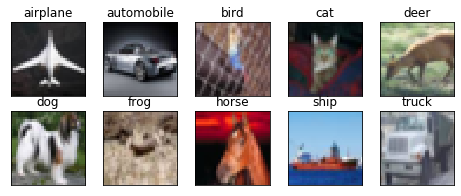

In [106]:

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Pick 4 images from the test dataset for inspection

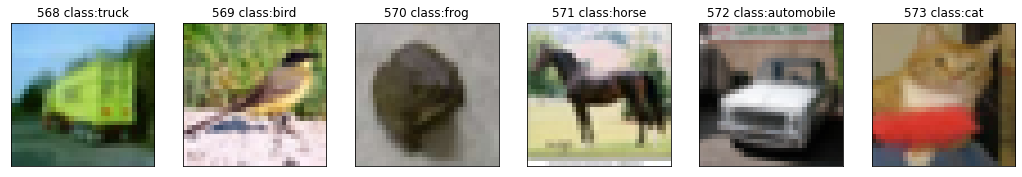

In [170]:
img_no = 6
rand_id = 568

fig = plt.figure(figsize=(18,3))
for i in range(img_no):
  ax = fig.add_subplot(1, 6, 1 + i, xticks=[], yticks=[])
  ax.set_title(str(rand_id + i) + " class:" + class_names[np.argmax(test_labels[rand_id + i])])
  plt.imshow(test_features[rand_id + i])
plt.show()


In [111]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3))) # output 32
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 32
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 16
#model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 16
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 16
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 8
#model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) # output 8
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) # output 8
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 4
#model.add(Dropout(0.5))

model.add(Convolution2D(4, 1))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(10, 4))
model.add(Flatten())


model.add(Activation('softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=15)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
390/390 [==============================] - 33s 84ms/step - loss: 1.3317 - acc: 0.5375 - val_loss: 1.1351 - val_acc: 0.6300
Epoch 2/15
390/390 [==============================] - 30s 76ms/step - loss: 0.8596 - acc: 0.7180 - val_loss: 0.9466 - val_acc: 0.6927
Epoch 3/15
390/390 [==============================] - 29s 75ms/step - loss: 0.6941 - acc: 0.7778 - val_loss: 0.7329 - val_acc: 0.7660
Epoch 4/15
390/390 [==============================] - 29s 76ms/step - loss: 0.5890 - acc: 0.8200 - val_loss: 0.8671 - val_acc: 0.7362
Epoch 5/15
390/390 [==============================] - 29s 75ms/step - loss: 0.5139 - acc: 0.8491 - val_loss: 0.8300 - val_acc: 0.7558
Epoch 6/15
390/390 [==============================] - 29s 75ms/step - loss: 0.4404 - acc: 0.8781 - val_loss: 0.7798 - val_acc: 0.7787
Epoch 7/15
390/390 [==============================] - 29s 75ms/step - loss: 0.3847 - acc: 0.9019 - val_loss: 0.9128 - val_acc: 0.7658
Epoch 8/15
390/390 [==============================] - 30s 76ms

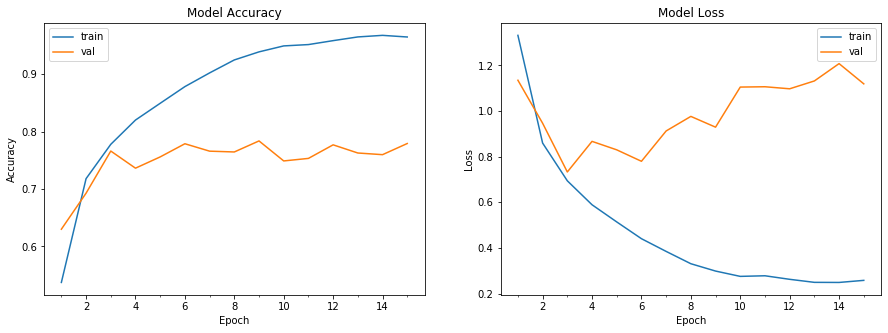

Accuracy on test data is: 77.91


In [112]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 15, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
#Function to plot original image and GradCAM image
def plotOrigGradCam(image_number, layer, model, alpha):
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
  
  # Pixel normalization for test images
  train_features = train_features.astype('float32')/255

  # convert class labels to binary class labels
  train_labels = np_utils.to_categorical(train_labels, num_classes)
  
  img = train_features[image_number]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(96):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  #print(conv_layer_output_value)  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  #heatmap = np.linalg.inv(heatmap)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  #heatmap = np.flipud(heatmap)

  print("Heatmap before colormap")
  plt.imshow(heatmap)
  plt.show()

  #print("Heatmap after color map")
  #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #plt.imshow(heatmap)
  #plt.show()

  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

  upsample = cv2.resize(heatmap, (32,32))
  upsample = np.uint8(255 - (255 * upsample))
  upsample = cv2.applyColorMap(upsample, cv2.COLORMAP_JET)
  
  print("Heatmap after colormap")
  plt.imshow(upsample)
  plt.show()
  
  plt.imshow(train_features[image_number])
  plt.imshow(upsample,alpha=alpha)
  plt.show()

  superimposed_img = cv2.addWeighted(img, 0.7, upsample, 0.3, 0)
  plt.imshow(superimposed_img)
  plt.show()

  """
  img = train_features[image_number]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  print("Heatmap")
  #print(heatmap)
  plt.imshow(heatmap)
  plt.show()
  superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
  #plt.title("Original: " + getClassName(test_labels[image_number])+"    Predicted: " + getClassName(class_idx))
  plt.imshow(img)
  plt.show()
  plt.imshow(superimposed_img)
  plt.show()
  cv2.waitKey(0)
  """

In [0]:
#Function to plot original image and GradCAM image
def getGradCam(image_number, layer, model):
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
  
  # Pixel normalization for test images
  test_features = test_features.astype('float32')/255

  # convert class labels to binary class labels
  test_labels = np_utils.to_categorical(test_labels, num_classes)
  
  img = test_features[image_number]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(96):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  #print(conv_layer_output_value)  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  #print("Heatmap before colormap")
  #plt.imshow(heatmap)
  #plt.show()

  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
  
  img = test_features[image_number]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 - (255 * heatmap))
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #print("Heatmap")
  #print(heatmap)
  #plt.imshow(heatmap)
  #plt.show()
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.2, 0)
  #plt.title("Original: " + getClassName(test_labels[image_number])+"    Predicted: " + getClassName(class_idx))
  #plt.imshow(img)
  #plt.show()
  #plt.imshow(superimposed_img)
  #plt.show()
  #cv2.waitKey(0)
  return heatmap, superimposed_img, class_idx

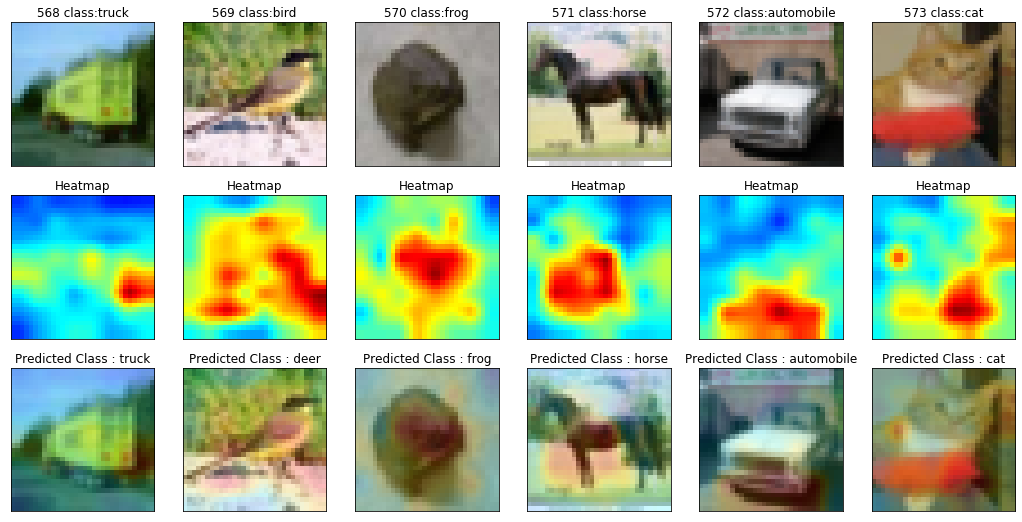

In [176]:

p = 0
img_no = 6
rand_id = 568

fig = plt.figure(figsize=(18,9))
for i in range(img_no):
  #print(rand_id)
  n = rand_id + i
  #print(n)
  h, s, c = getGradCam(n, "activation_14", model)
  p = i + 1
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title(str(rand_id + i) + " class:" + class_names[np.argmax(test_labels[rand_id + i])])
  plt.imshow(test_features[rand_id + i])
  p = p + 6
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title("Heatmap")
  plt.imshow(h)
  p = p + 6
  ax = fig.add_subplot( 3, 6, p, xticks=[], yticks=[])
  ax.set_title("Predicted Class : " + class_names[c])
  plt.imshow(s)
plt.show()

In [0]:
x = train_features[125].reshape(1,32,32,3)
x

array([[[[1.        , 1.        , 1.        ],
         [0.9843137 , 0.9764706 , 0.9882353 ],
         [0.9843137 , 0.98039216, 0.9882353 ],
         ...,
         [0.9882353 , 0.9882353 , 0.9882353 ],
         [0.9843137 , 0.9843137 , 0.9843137 ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [0.98039216, 0.99607843, 0.99607843],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [0.99607843, 0.99607843, 0.99607843],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [0.9764706 , 0.99215686, 0.9764706 ],
         [0.92156863, 0.90588236, 0.8862745 ],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [0.99607843, 0.99607843, 0.99607843]

In [0]:
x = preprocess_input(x)
x

array([[[[-310.81702, -349.337  , -370.04   ],
         [-310.82877, -349.36053, -370.0557 ],
         [-310.82877, -349.3566 , -370.0557 ],
         ...,
         [-310.82877, -349.34875, -370.05176],
         [-310.8327 , -349.3527 , -370.0557 ],
         [-310.81702, -349.337  , -370.04   ]],

        [[-310.81702, -349.337  , -370.04   ],
         [-310.82092, -349.3409 , -370.0596 ],
         [-310.81702, -349.337  , -370.04   ],
         ...,
         [-310.81702, -349.337  , -370.04   ],
         [-310.82092, -349.3409 , -370.0439 ],
         [-310.81702, -349.337  , -370.04   ]],

        [[-310.81702, -349.337  , -370.04   ],
         [-310.84055, -349.34485, -370.06354],
         [-310.93073, -349.43112, -370.11844],
         ...,
         [-310.82092, -349.3409 , -370.0439 ],
         [-310.82092, -349.3409 , -370.0439 ],
         [-310.81702, -349.337  , -370.04   ]],

        ...,

        [[-310.81702, -349.337  , -370.04   ],
         [-310.82092, -349.3409 , -370.0439 ]

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
class_output

<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [0]:
conv_layer = model.get_layer("conv2d_8")
grads = K.gradients(class_output, conv_layer.output)[0]
grads

<tf.Tensor 'gradients/activation_6/Relu_grad/ReluGrad:0' shape=(?, 8, 8, 256) dtype=float32>

In [0]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))
pooled_grads

<tf.Tensor 'Mean:0' shape=(256,) dtype=float32>

In [0]:
iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
conv_layer_output_value_preserve = conv_layer_output_value
conv_layer_output_value_preserve

array([[[ 6.88997540e-11,  3.78170889e-12,  1.50599823e-12, ...,
         -6.31739073e-13,  3.67787094e-12,  2.28783832e-11],
        [ 4.28002182e-11,  1.95030537e-12, -1.62984643e-11, ...,
          5.76657298e-12,  2.03566990e-11,  2.47183107e-11],
        [-1.07232973e-11, -9.06543764e-12, -1.45198428e-11, ...,
         -7.03000783e-11,  1.11973026e-11,  3.16686781e-11],
        ...,
        [ 3.87075337e-11, -2.19835239e-12, -8.83787835e-12, ...,
          1.26554192e-11,  8.21676407e-12,  2.62250746e-12],
        [ 3.10637523e-11,  9.77485237e-13,  2.80404519e-12, ...,
          5.41241357e-11,  4.02394567e-12, -5.85543029e-12],
        [ 3.52723545e-11,  1.31033660e-12, -2.72068934e-12, ...,
          1.83060320e-11,  3.58044107e-12, -5.79193106e-13]],

       [[ 3.17609376e-11,  4.90587041e-12, -3.58690616e-12, ...,
          2.47354897e-11,  1.85198662e-11,  2.43157508e-11],
        [-1.06633771e-10,  9.13125305e-12, -2.70031341e-11, ...,
          9.68766109e-11,  3.54236120e

#### Implementing GradCAM

In [0]:
x = train_features[125].reshape(1,32,32,3)
x = preprocess_input(x)
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]

conv_layer = model.get_layer("conv2d_8") # interested layer of inspection

grads = K.gradients(class_output, conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
conv_layer_output_value

array([[[ 6.88997540e-11,  3.78170889e-12,  1.50599823e-12, ...,
         -6.31739073e-13,  3.67787094e-12,  2.28783832e-11],
        [ 4.28002182e-11,  1.95030537e-12, -1.62984643e-11, ...,
          5.76657298e-12,  2.03566990e-11,  2.47183107e-11],
        [-1.07232973e-11, -9.06543764e-12, -1.45198428e-11, ...,
         -7.03000783e-11,  1.11973026e-11,  3.16686781e-11],
        ...,
        [ 3.87075337e-11, -2.19835239e-12, -8.83787835e-12, ...,
          1.26554192e-11,  8.21676407e-12,  2.62250746e-12],
        [ 3.10637523e-11,  9.77485237e-13,  2.80404519e-12, ...,
          5.41241357e-11,  4.02394567e-12, -5.85543029e-12],
        [ 3.52723545e-11,  1.31033660e-12, -2.72068934e-12, ...,
          1.83060320e-11,  3.58044107e-12, -5.79193106e-13]],

       [[ 3.17609376e-11,  4.90587041e-12, -3.58690616e-12, ...,
          2.47354897e-11,  1.85198662e-11,  2.43157508e-11],
        [-1.06633771e-10,  9.13125305e-12, -2.70031341e-11, ...,
          9.68766109e-11,  3.54236120e

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap

array([[ 1.93769740e-12, -1.19679596e-11, -1.47554087e-11,
        -7.99834331e-12, -9.63565382e-13,  5.03308419e-12,
         2.59690555e-12,  3.19380113e-12],
       [ 3.59753416e-12, -4.75604105e-12, -1.06721455e-11,
         4.87272223e-13,  9.65966109e-12,  9.28724458e-12,
         2.53898508e-12,  4.19181356e-12],
       [ 1.08844639e-12, -9.71510112e-12, -8.11410748e-12,
         7.49397940e-12,  1.39291755e-11,  8.90740606e-12,
         2.76040323e-12,  1.18755028e-12],
       [-6.11781372e-12, -1.08039437e-11, -8.75639665e-12,
         1.45046562e-12,  1.10729681e-11,  4.80135896e-12,
        -1.93638898e-12, -1.73946263e-12],
       [-4.40942768e-12, -4.12589797e-12, -1.13310854e-11,
        -3.18088438e-12, -3.11043487e-12, -2.48078684e-12,
        -5.40000423e-12, -3.33384492e-12],
       [-2.83789528e-12,  1.73282601e-12, -5.43902163e-12,
        -4.60736874e-12,  6.21083046e-13,  6.57469825e-12,
         3.31174563e-12,  1.91436146e-12],
       [-8.70107111e-12, -8.834172

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [0]:
heatmap

array([[0.1391107 , 0.        , 0.        , 0.        , 0.        ,
        0.36133397, 0.18643641, 0.2292886 ],
       [0.2582733 , 0.        , 0.        , 0.03498213, 0.69348407,
        0.6667476 , 0.1822782 , 0.30093765],
       [0.07814148, 0.        , 0.        , 0.53800595, 1.        ,
        0.6394783 , 0.19817421, 0.08525632],
       [0.        , 0.        , 0.        , 0.10413148, 0.79494786,
        0.344698  , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.12440263, 0.        , 0.        , 0.04458864,
        0.47200915, 0.23775604, 0.13743538],
       [0.        , 0.        , 0.        , 0.        , 0.12320982,
        0.43355405, 0.35449433, 0.30957797],
       [0.        , 0.        , 0.        , 0.03248383, 0.4479531 ,
        0.76590896, 0.5065164 , 0.3626992 ]], dtype=float32)

In [0]:
superimposed_img = cv2.addWeighted(train_features[125], 0.6, heatmap, 0.4, 0)
cv2.imshow("GradCam", superimposed_img)
cv2.waitKey(0)

error: ignored

In [0]:
np.argmax(model.predict(test_features[127].reshape(1, 32, 32, 3)))

3

In [0]:
np.argmax(test_labels[127])

3

In [0]:
heatmap.shape

(8, 8)

In [0]:
train_features[125].shape

(32, 32, 3)

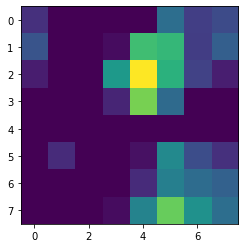

In [0]:
plt.imshow(heatmap)

In [0]:
import cv2
import skimage.transform as skim

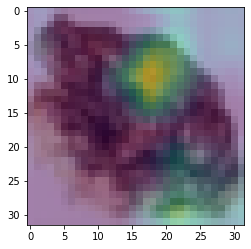

In [0]:
upsample = skim.resize(heatmap, (32,32),preserve_range=True)
plt.imshow(train_features[125])
plt.imshow(upsample,alpha=0.5)
plt.show()

In [0]:
import tensorflow as tf
import skimage.transform as skim
conv_layer = model.get_layer("conv2d_8")

In [0]:
x = train_features[128].reshape(1,32,32,3)
x = preprocess_input(x)
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print("class_idx : ", class_idx)
class_output = model.output[:, class_idx]
print("class_output : ", tf.print(class_output))
print("conv_layer : ", conv_layer)
grads = K.gradients(class_output, conv_layer.output)[0]
print("grads : ", tf.print(grads))
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print("pooled_grads : ", tf.print(pooled_grads))
iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
print("iterate : ", iterate)
pooled_grads_value, conv_layer_output_value = iterate([x])
print("pooled_grads_value : ", pooled_grads_value)
print("conv_layer_output_value : ", conv_layer_output_value)
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
conv_layer_output_value

class_idx :  9
class_output :  name: "PrintV2_9"
op: "PrintV2"
input: "StringFormat_9"
attr {
  key: "end"
  value {
    s: "\n"
  }
}
attr {
  key: "output_stream"
  value {
    s: "stderr"
  }
}

conv_layer :  <keras.layers.convolutional.Conv2D object at 0x7f7ac03ec668>
grads :  name: "PrintV2_10"
op: "PrintV2"
input: "StringFormat_10"
attr {
  key: "end"
  value {
    s: "\n"
  }
}
attr {
  key: "output_stream"
  value {
    s: "stderr"
  }
}

pooled_grads :  name: "PrintV2_11"
op: "PrintV2"
input: "StringFormat_11"
attr {
  key: "end"
  value {
    s: "\n"
  }
}
attr {
  key: "output_stream"
  value {
    s: "stderr"
  }
}

iterate :  <keras.backend.tensorflow_backend.Function object at 0x7f7a6cdee4e0>
pooled_grads_value :  [ 1.00134859e-15  2.03655604e-15 -5.84475180e-15 -1.33870074e-15
  5.32735125e-16 -4.25417936e-15 -1.38265529e-16  1.71523462e-15
  7.79860693e-16  2.77185391e-15  1.74179170e-16 -1.40947564e-15
 -5.35569086e-16 -2.47930864e-15 -1.61235443e-15 -4.11852788e-15
  

array([[[ 1.19911066e-13,  9.60572428e-14,  3.04426487e-14, ...,
          2.61635043e-14, -3.40657339e-14,  2.63827426e-13],
        [ 3.38348768e-14, -5.94659142e-14,  1.87149219e-13, ...,
         -6.14665247e-14, -8.89658716e-16,  2.55407701e-13],
        [ 1.15602067e-13, -2.89164363e-13,  4.60873798e-13, ...,
         -1.14156189e-13,  4.06791232e-14,  1.31783487e-13],
        ...,
        [ 7.41060113e-14,  2.81739394e-13,  1.54880807e-12, ...,
         -2.22921199e-15,  5.31766132e-14,  4.14953682e-14],
        [ 4.30535090e-14, -1.54999725e-13, -7.72821260e-13, ...,
         -1.60590589e-13, -1.63773563e-13, -1.55045552e-14],
        [ 5.74776229e-15, -1.40772891e-13,  4.53099819e-15, ...,
         -1.24369387e-13,  1.25966335e-13,  5.88560708e-14]],

       [[ 1.94671905e-14,  4.13785657e-14, -1.98479986e-13, ...,
         -3.32958758e-14,  4.12316750e-15,  3.13620251e-13],
        [ 1.34505186e-13, -2.20408354e-13,  1.23919294e-13, ...,
         -8.24582712e-14,  9.02957925e

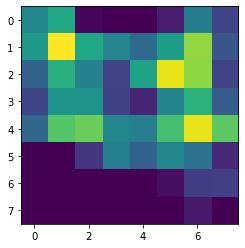

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

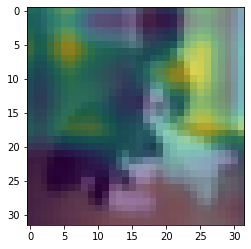

In [0]:
upsample = skim.resize(heatmap, (32,32),preserve_range=True)
plt.imshow(train_features[128])
plt.imshow(upsample,alpha=0.5)
plt.show()

In [0]:
train_features[126].shape

(32, 32, 3)

In [0]:
list1 = [1,2,3,4,5]
list2 = [6,7,8,,9,10]

In [0]:
list3 = lis